In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import scipy.stats as stats
import seaborn.apionly as sns
import statsmodels.api as sm
import theano.tensor as tt

from sklearn import preprocessing

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

/Users/paul.pop/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/paul.pop/anaconda3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)
/Users/paul.pop/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
import sys, os
sys.path.append(os.getcwd().split('notebooks')[0])
import utils

/Users/paul.pop/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [4]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 

In [5]:
IMC_basedir = os.getcwd().split('code')[0]
DATA_AMELIA_FILE = os.path.join(IMC_basedir, 'data/imputed_dataset_no_censoring_26022018_Amelia1.csv')
DATA_MICE_FILE = os.path.join(IMC_basedir, 'data/imputed_dataset_no_censoring_26022018_MICE.csv')
TRAIN_FILE = os.path.join(IMC_basedir, 'data/amelia_train')
TEST_FILE = os.path.join(IMC_basedir, 'data/amelia_test')
MODEL_DIR = os.path.join(IMC_basedir, 'data/amelia_model')

In [6]:
df, labels = utils.process_amelia(DATA_AMELIA_FILE)
X_train, Y_train, X_test, Y_test = utils.get_train_test_data(df, regression=False, train_size=0.8)

# Pymc3

In [ ]:
_, num_X = X_train.shape

with pm.Model() as model:       
    intercept = pm.Normal('intercept', mu=0, sd=100)
    beta_gender = pm.Normal('beta_gender', mu=0, sd=100)
    beta_IK = pm.Normal('beta_IK', mu=0, sd=100)
    beta_age_surgery = pm.Normal('beta_age_surgery', mu=0, sd=100)
    mu = tt.exp(intercept 
                + beta_gender*df.Gender 
                + beta_IK*df.IK
                + beta_age_surgery*df.Age_surgery)
    
    y_est = pm.Poisson('y_est', mu=mu, observed=df['life_expectancy'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

In [ ]:
_ = pm.traceplot(trace)

In [ ]:
_ = sns.pairplot(pm.trace_to_dataframe(trace[20000:]), plot_kws={'alpha':.5})

In [ ]:
trace['beta_age_surgery']

In [ ]:
# 'Gender', 'Tumor_grade', '', 'life_expectancy', 'IDH_TERT',
#        '', 'life_expectancy_bin', '', '',
#        '', '', 'Gene_Cdk4_NORMAL',
#        '', 'X1p19q_codel_1', 'IDH_NC', 'IDH_mutant', 'IDH_wt',
#        'TERT_mutant', 'TERT_wt', '', '',
#        '', '', '',
#        '', '', '',
#        'Tumor_Position_médian', 'Tumor_Position_non précisé',
#        '', '',
#        'Gene_Ihc_Atrx_Extinction diffuse', 'Gene_Ihc_Atrx_Maintien',
#        'Gene_Ihc_Atrx_extinction', 'Tumor_type_GBM', 'Tumor_type_astrocytome',
#        'Tumor_type_astrocytome gémistocytique (=A2)',
#        'Tumor_type_astrocytome pilocytique', 'Tumor_type_gangliogliome',
#        'Tumor_type_gliome', 'Tumor_type_oligo', '',
#        '', '', '',
#        'Gene_Mgmt_METHYLE', 'Gene_Mgmt_NON METHYLE', 'Surgery_type_aucune',
#        'Surgery_type_biopsie', 'Surgery_type_exérèse',
#        'Surgery_type_partielle', 'Gene_P53_ALTERE', 'Gene_P53_NC',
#        'Gene_P53_NORMAL', 'Gene_Ch10Q_NON PERTE', 'Gene_Ch10Q_PERTE'

### Functions

In [8]:
#TODO
# def get_categorical_arg(df_data, column_name):
#     return pm.Categorical(name='beta_' + column_name, p=df_data[column_name].mean())

def get_binary_arg(df_data, column_name):
    return pm.Bernoulli(name='beta_' + column_name, p=df_data[column_name].mean())

def get_numerical_arg(df_data, column_name):
    return pm.Normal('beta_' + column_name, mu=df_data[column_name].mean(), sd=df_data[column_name].std())

In [ ]:
_, num_X = X_train.shape

with pm.Model() as model:       
    intercept = pm.Normal('intercept', mu=50, sd=100)
    mu = tt.exp(intercept 
                + get_binary_arg(df, 'Gender') * df.Gender  
                + get_binary_arg(df, 'Gene_Ch9P_GAIN') * df.Gene_Ch9P_GAIN  
                #+ get_binary_arg(df, 'Gene_Ch9P_NON PERTE') * df.Gene_Ch9P_  #Bine ca n-ai putut pune liniuta
#                 + get_binary_arg(df, 'Tumor_Location_A') * df.Tumor_Location_A  
#                 + get_binary_arg(df, 'Tumor_Location_B') * df.Tumor_Location_B  
#                 + get_binary_arg(df, 'Tumor_Location_C') * df.Tumor_Location_C  
#                 + get_binary_arg(df, 'Tumor_Position_D') * df.Tumor_Position_D  # De ce e position si nu location?
#                 + get_binary_arg(df, 'Tumor_Position_G') * df.Tumor_Position_G 
#                 + get_binary_arg(df, 'Tumor_Location_N') * df.Tumor_Location_N 
#                 + get_binary_arg(df, 'Tumor_Position_bilatéral') * df.Tumor_Position_bilatéral 
#                 + get_binary_arg(df, 'Gene_Mdm2_AMPLIFIE') * df.Gene_Mdm2_AMPLIFIE 
#                 + get_binary_arg(df, 'Gene_Mdm2_NORMAL') * df.Gene_Mdm2_NORMAL 
#                 + get_binary_arg(df, 'Gene_P16_DELETE') * df.Gene_P16_DELETE 
#                 + get_binary_arg(df, 'Gene_P16_NORMAL') * df.Gene_P16_NORMAL 
#                 + get_binary_arg(df, 'Gene_Egfr_AMPLIFIE') * df.Gene_Egfr_AMPLIFIE 
#                 + get_binary_arg(df, 'Gene_Egfr_NORMAL') * df.Gene_Egfr_NORMAL 
#                 + get_binary_arg(df, 'Gene_Cdk4_AMPLIFIE') * df.Gene_Cdk4_AMPLIFIE 
#                 + get_binary_arg(df, 'Gene_Ch9P_PERTE') * df.Gene_Ch9P_PERTE 
                + get_binary_arg(df, 'X1p19q_codel_0') * df.X1p19q_codel_0 
                + get_binary_arg(df, 'Tumor_Location_autre') * df.Tumor_Location_autre 
                + get_numerical_arg(df, 'IK') * df.IK
                + get_numerical_arg(df, 'Age_surgery') * df.Age_surgery
               )
    
    y_est = pm.Poisson('y_est', mu=mu, observed=df['life_expectancy'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

In [10]:
_ = pm.traceplot(trace)

NameError: name 'trace' is not defined

# Compute posterior 

In [12]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return stats.norm(mu_post, np.sqrt(sigma_post)).pdf(x)

def plot_posterior(data, column):
    ax = plt.subplot()
    x = np.linspace(-1, 1, 500)
    posterior_analytical = calc_posterior_analytical(data[column], x, 0., 1.)
    ax.plot(x, posterior_analytical)
    ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior {}'.format(column));
    sns.despine()
    plt.show()

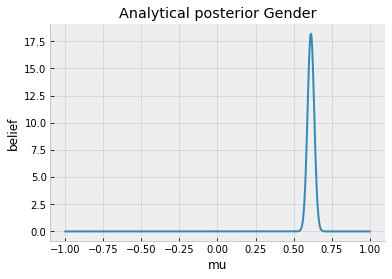

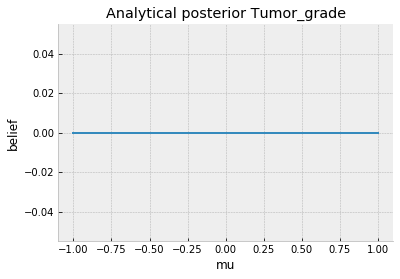

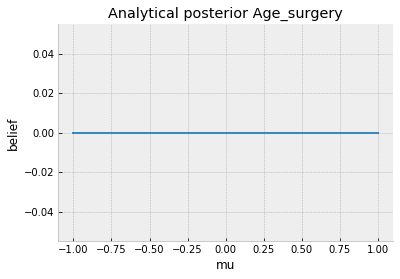

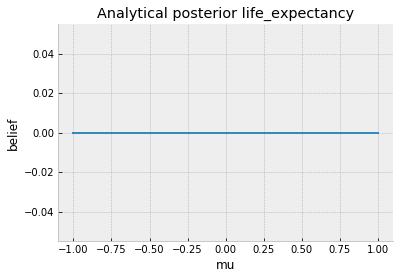

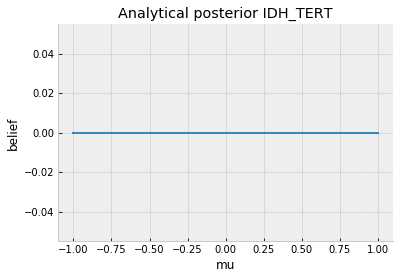

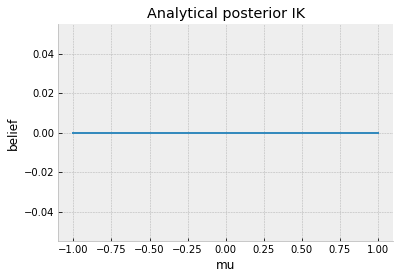

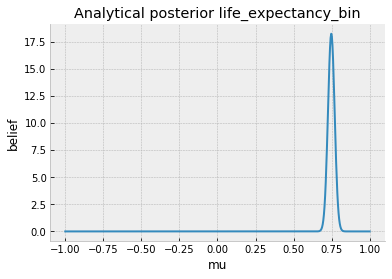

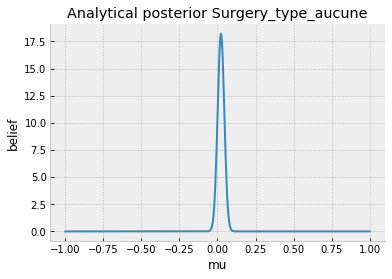

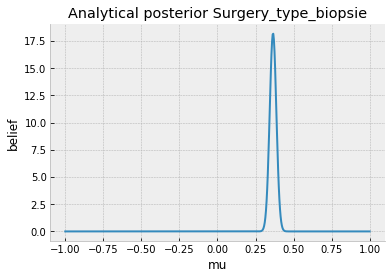

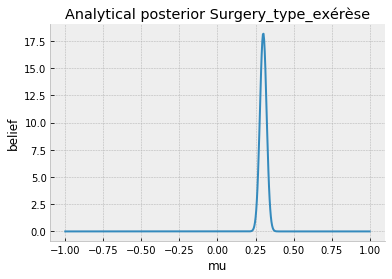

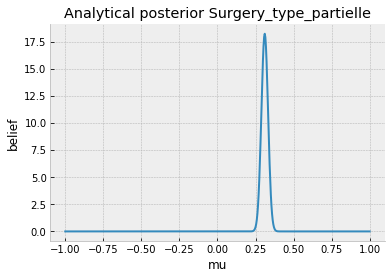

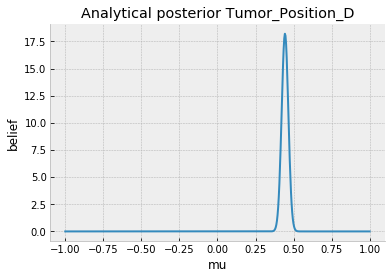

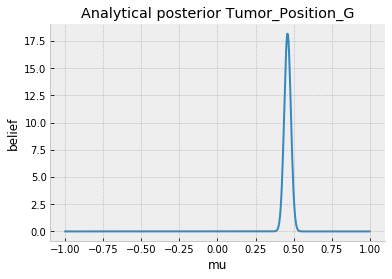

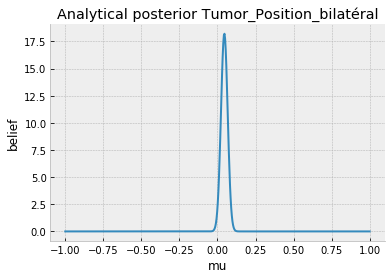

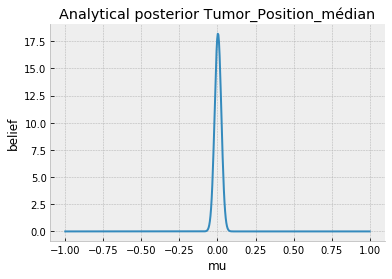

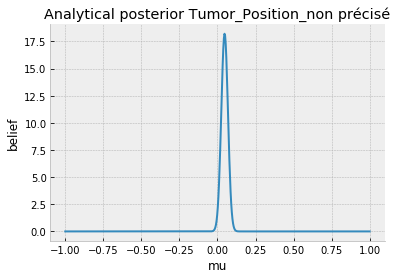

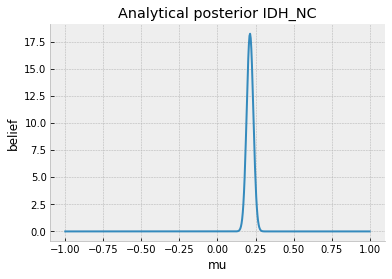

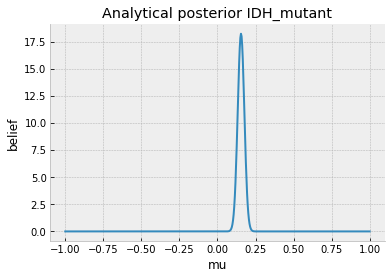

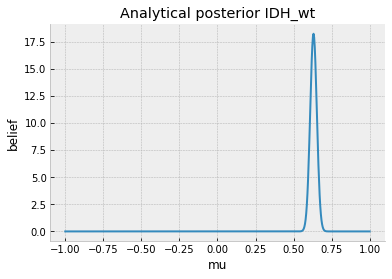

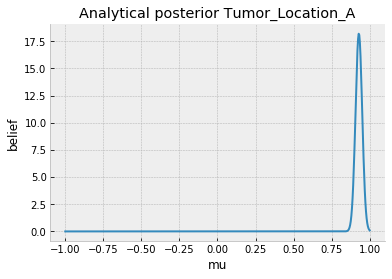

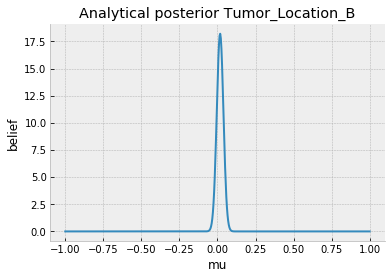

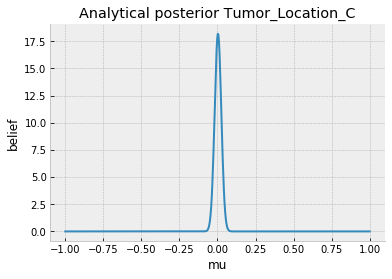

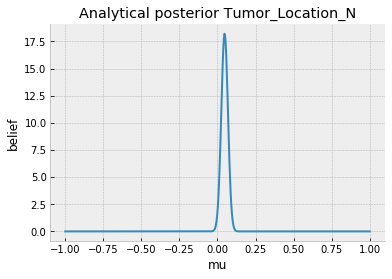

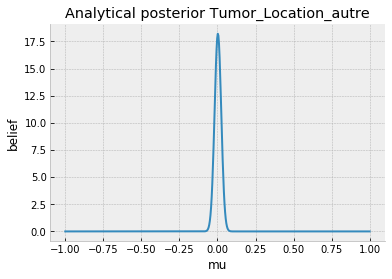

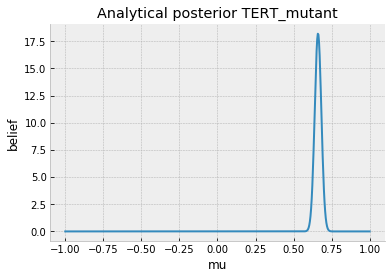

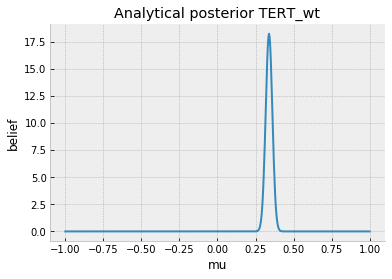

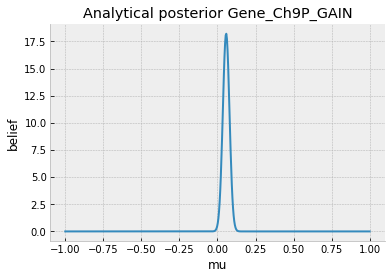

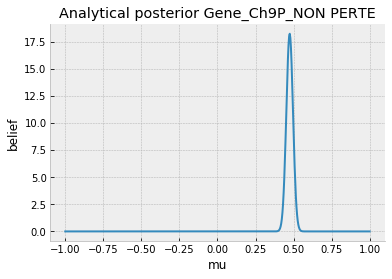

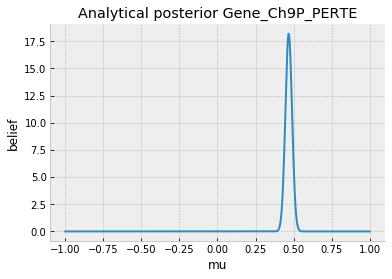

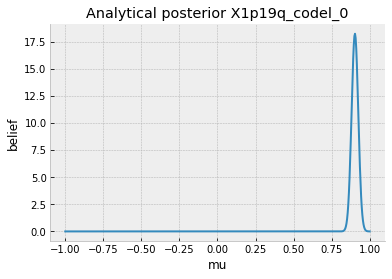

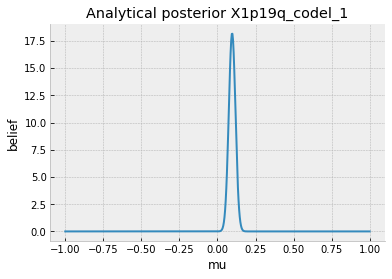

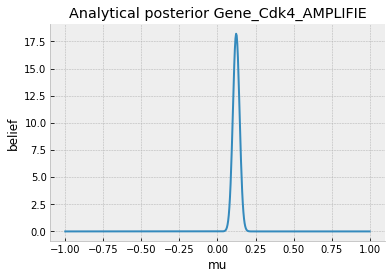

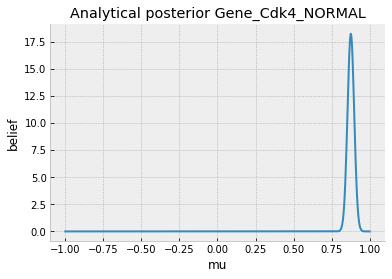

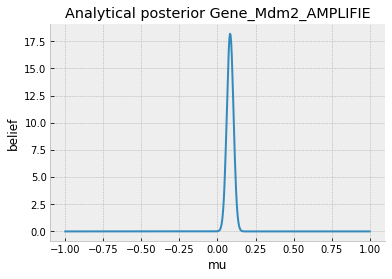

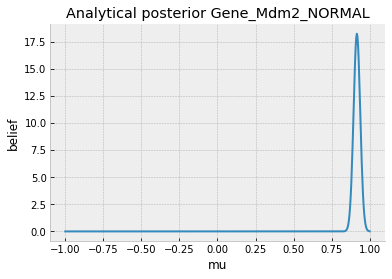

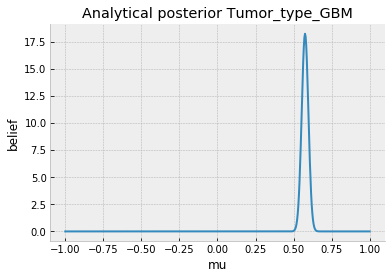

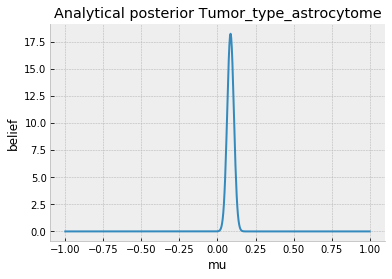

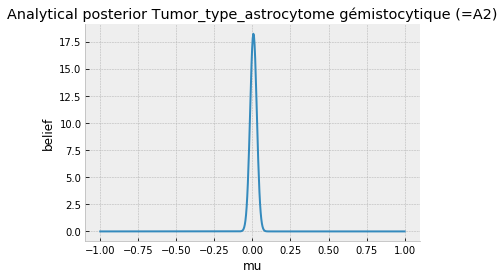

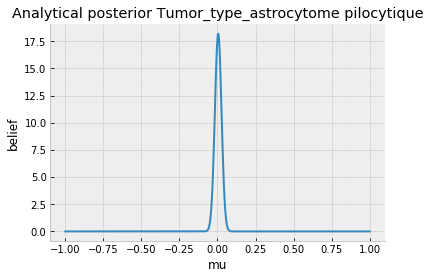

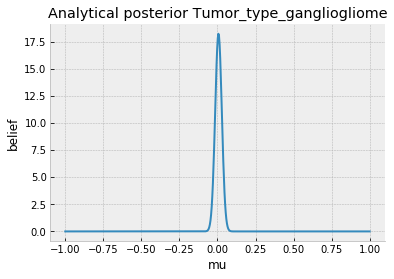

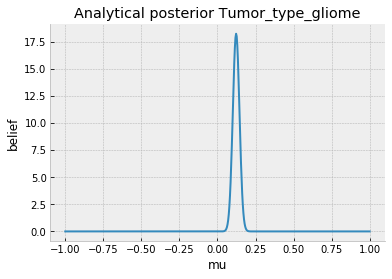

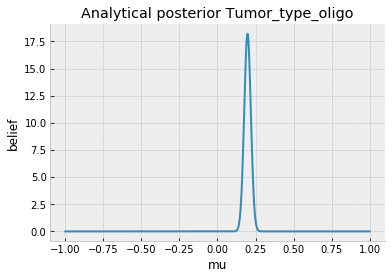

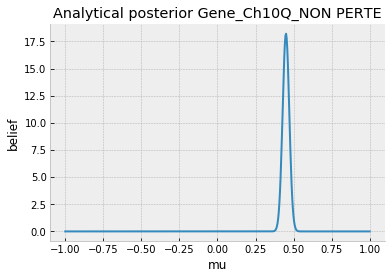

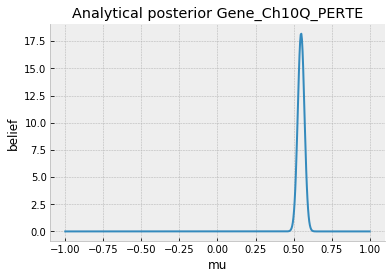

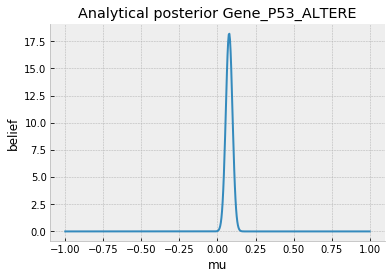

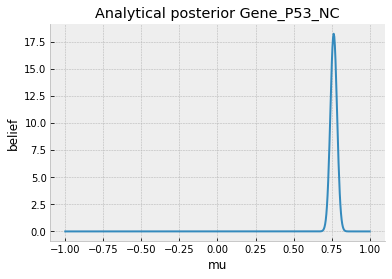

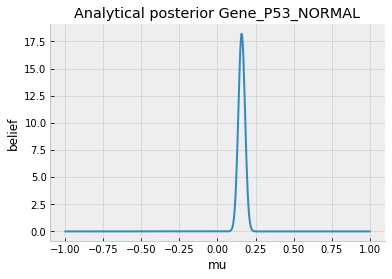

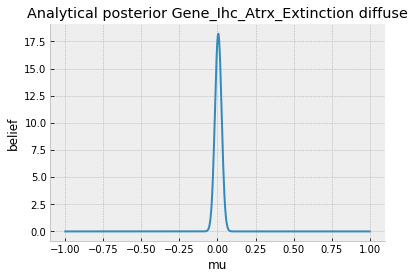

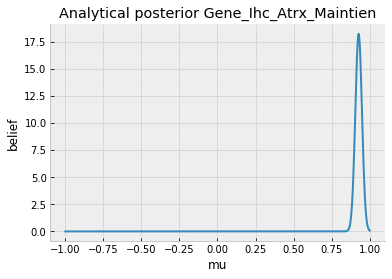

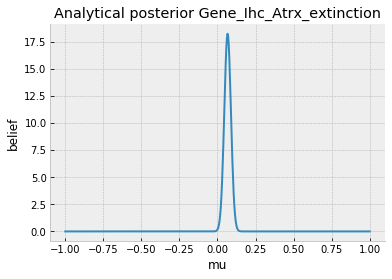

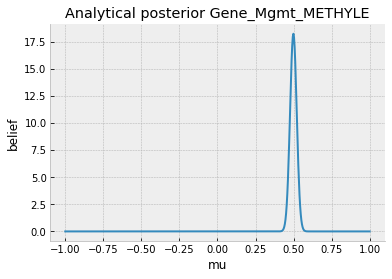

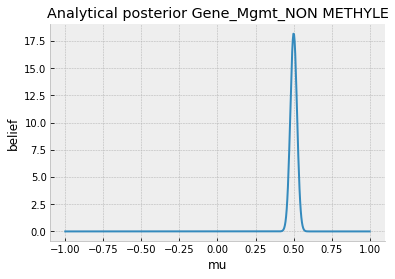

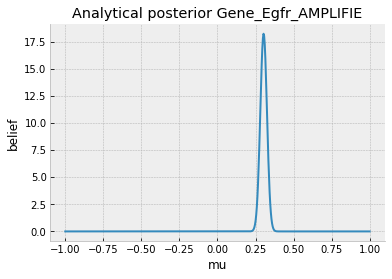

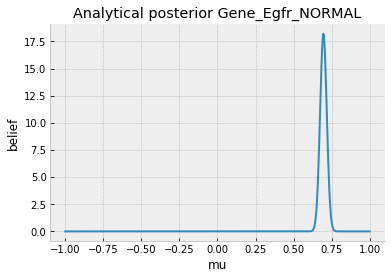

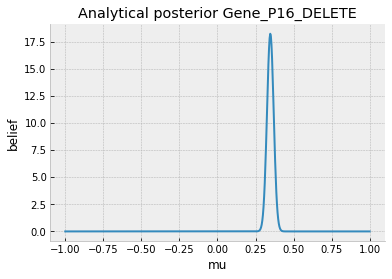

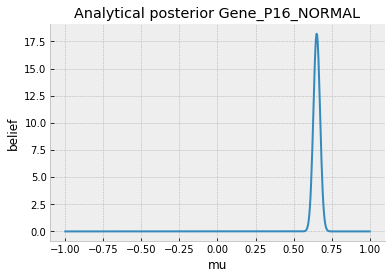

In [86]:
for col in df.columns:
    plot_posterior(df, col)

# Sampler 

In [54]:
# Tried my own sampler

# def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1., sd_init=1.):
#     mu_current = mu_init
#     posterior = [mu_current]
#     for i in range(samples):
#         # suggest new position
#         mu_proposal = stats.norm(mu_current, proposal_width).rvs()
#         print(mu_proposal)

#         # Compute likelihood by multiplying probabilities of each data point
#         current = stats.norm(mu_current, sd_init).pdf(data)
#         proposal = stats.norm(mu_proposal, sd_init).pdf(data)
#         likelihood_current = current[current.nonzero()].prod()
#         likelihood_proposal = proposal[proposal.nonzero()].prod()
#         print(likelihood_current)
#         print(likelihood_proposal)
#         print('----')
#         # Compute prior probability of current and proposed mu        
#         prior_current = stats.norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
#         prior_proposal = stats.norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
#         p_current = likelihood_current * prior_current
#         p_proposal = likelihood_proposal * prior_proposal
        
#         # Accept proposal?
#         p_accept = p_proposal / p_current
        
#         # Usually would include prior probability, which we neglect here for simplicity
#         accept = np.random.rand() < p_accept
        
#         if plot or i == samples - 1:
#             plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
#         if accept:
#             # Update position
#             mu_current = mu_proposal
            
#         posterior.append(mu_current)
        
#     return posterior

# # Function to display
# def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
#     from copy import copy
#     trace = copy(trace)
#     fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
#     fig.suptitle('Iteration %i' % (i + 1))
#     x = np.linspace(-3, 3, 5000)
#     color = 'g' if accepted else 'r'
        
#     # Plot prior
#     prior_current = stats.norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
#     prior_proposal = stats.norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
#     prior = stats.norm(mu_prior_mu, mu_prior_sd).pdf(x)
#     ax1.plot(x, prior)
#     ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
#     ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
#     ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
#                  arrowprops=dict(arrowstyle="->", lw=2.))
#     ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
#     # Likelihood
#     likelihood_current = stats.norm(mu_current, 1).pdf(data).prod()
#     likelihood_proposal = stats.norm(mu_proposal, 1).pdf(data).prod()
#     y = stats.norm(loc=mu_proposal, scale=1).pdf(x)
#     sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
#     ax2.plot(x, y, color=color)
#     ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
#     ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
#     #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
#     ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
#                  arrowprops=dict(arrowstyle="->", lw=2.))
#     ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
#     # Posterior
#     posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
#     ax3.plot(x, posterior_analytical)
#     posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
#     posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
#     ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
#     ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
#     ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
#                  arrowprops=dict(arrowstyle="->", lw=2.))
#     #x3.set(title=r'prior x likelihood $\propto$ posterior')
#     ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
#     if accepted:
#         trace.append(mu_proposal)
#     else:
#         trace.append(mu_current)
#     ax4.plot(trace)
#     ax4.set(xlabel='iteration', ylabel='mu', title='trace')
#     plt.tight_layout()
#     #plt.legend()

In [63]:
# Pymc Sampler
def sampler(data, column, plot=False, samples=15000):
    with pm.Model():
        mu = pm.Normal('mu', 0, 1)
        sigma = 1.
        returns = pm.Normal('returns', mu=mu, sd=sigma, observed=data[column])

        step = pm.Metropolis()
        trace = pm.sample(samples, step)
        
    if plot:
        sns.distplot(posterior['mu'], label=column);
        plt.legend();
        
        fig, ax = plt.subplots()
        ax.plot(posterior)
        _ = ax.set(xlabel='sample', ylabel='mu', title=column);
    return trace

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu]
100%|██████████| 15500/15500 [00:01<00:00, 9598.66it/s]
The number of effective samples is smaller than 10% for some parameters.


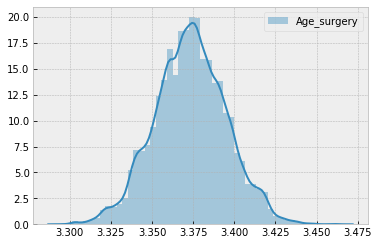

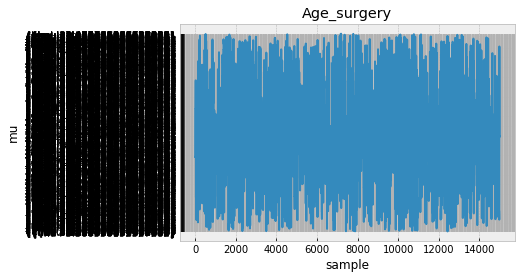

In [64]:
col = 'Age_surgery'
posterior = sampler(df, col, plot=True)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu]
100%|██████████| 15500/15500 [00:01<00:00, 8891.14it/s]
The number of effective samples is smaller than 10% for some parameters.


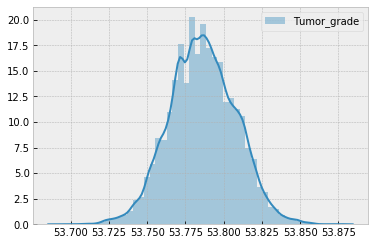

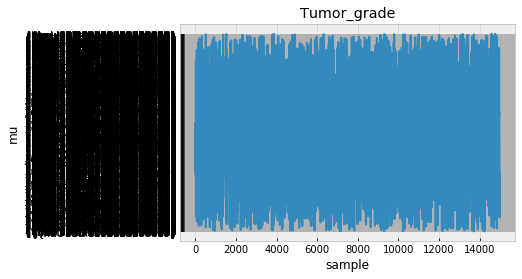

In [65]:
col = 'Tumor_grade'
posterior = sampler(df, col, plot=True)

(array([  24.,    0.,    0.,  370.,    0.,    0.,  491.,    0.,    0.,
        1201.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

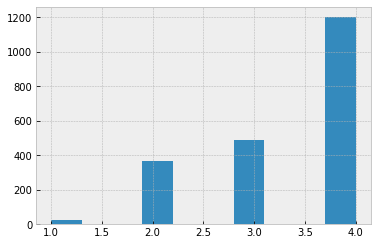

In [71]:
plt.hist(df['Tumor_grade'].values)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu]
100%|██████████| 15500/15500 [00:01<00:00, 9682.63it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


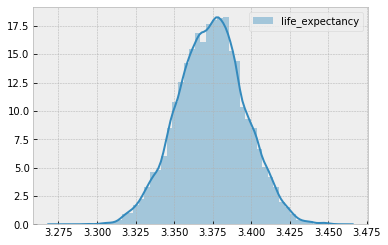

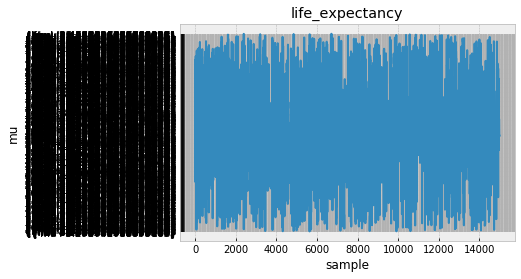

In [66]:
col = 'life_expectancy'
posterior = sampler(df, col, plot=True)